# Air Quality Data Hack

## Exploring the data available from OpenAQ

OpenAQ is a free to use open source website that collects publically available air quality data. 
***
### Initial setup

Registering with your own API key allows faster access to the data: [https://api.openaq.org/register](https://api.openaq.org/register)

To use this notebook, add your unique API key to the `config.yml` file, which should be placed alongside the notebooks in your directory e.g.:

```
.
├── config.yml  <-----
├── data
├── data_prepared_earlier
├── download_meteorological_data.ipynb
├── download_openaq_leeds.ipynb
├── explore_openaq_data.ipynb
├── figs
├── metadata
├── ufuncs.py
├── visualise_openaq_data.ipynb
└── weather_data
```

The contents of `config.yml` should be 
```
openaq_api_key: **YOUR API KEY HERE**
```

***
### Make a list of all the of Air Quality monitoring stations in the OpenAQ database

The first step is to initialise the API and download a list of monitoring stations. We will use a the `openaq` Python package, along with a few other commonly used packages. To run this notebook you should make sure these are installed first.

In [1]:
import openaq
import yaml
import pandas as pd
import time

# these are a couple of functions I've written to help download data from the API
from ufuncs import response_to_dataframe, download_all_pages
# the code is a bit messy so I've hidden them in another script

In [2]:
# first retrieve your API key
with open("./config.yml", 'r') as ymlfile:
    API_KEY = yaml.safe_load(ymlfile)['openaq_api_key']

# initialise the OpenAQ client. This connects to the API
client = openaq.OpenAQ(api_key=API_KEY)

<div class="alert alert-block alert-info">
<b>Tip:</b> The password is stored in a seperate files as it is best practice not to store passwords in Jupyter notebooks so they are not mistakenly shared </div>

<div class="alert alert-block alert-info">
<b>Tip:</b> If you encounter an error at this stage, it is likely your API key or config.yml file are not correctly written/located </div>

In [3]:
# get a list of all locations in the OpenAQ database
locations_response = client.locations.list()

# we can extract the total number of locations from the metadata of the response
print(f'There are currently {locations_response.meta.found} locations in the OpenAQ data')


There are currently 50587 locations in the OpenAQ data


In [4]:
# the next step is to convert the locations into a pandas DataFrame using this function
locations_df = response_to_dataframe(locations_response)

print(f'locations_df dataframe is {len(locations_df)} rows long')

locations_df dataframe is 1000 rows long


This is because by default, the API only downloads the first 1000 rows of a response. But we know there are 50,000+ reponses, so we need to loop through each 'page' of the response to download the complete list of stations.

In [5]:
# we use the 'download all pages' function to download the entire list of stations
locations_df = download_all_pages(client.locations.list)

.....................................getting  exception
wating 2 seconds and retrying
..............

In [6]:
# then save the output as a csv file to avoid repeating this time-consuming step
print(f'now the DataFrame is {len(locations_df)} rows long')
locations_df.to_csv('locations_metadata.csv')

now the DataFrame is 50587 rows long


***
### Exploring the locations metadata
Now that the metadata of all the locations is saved, we can make a quick map showing all the station locations
First let's explore what kind of metadata is included

In [7]:
list(locations_df)

['name',
 'locality',
 'timezone',
 'is_mobile',
 'is_monitor',
 'instruments',
 'sensors',
 'bounds',
 'distance',
 'country.id',
 'country.code',
 'country.name',
 'owner.id',
 'owner.name',
 'provider.id',
 'provider.name',
 'coordinates.latitude',
 'coordinates.longitude',
 'datetime_first.utc',
 'datetime_first.local',
 'datetime_last.utc',
 'datetime_last.local']

The list of columns in the DataFrame shows that lots of useful metadata attributes are present. Each stations has a name, latitude longitude coordinates and the date and time of first and last measurements

Some other useful fields are:
* _instruments_: identifies the monitor as either a 'Government Monitor' or 'PurpleAir Sensor'
* _sensors_: list of the pollution or meteorological variables measured at each location

<div class="alert alert-block alert-info">
<b>Note:</b> A list of all the possible instruments/sensors/countries etc. can be retrieved from the API by running, e.g. <code>client.instruments.list()</code> </div>

***
### Making a map of all the locations
We can use the metadata to map the locations of all the monitoring stations in the OpenAQ database.

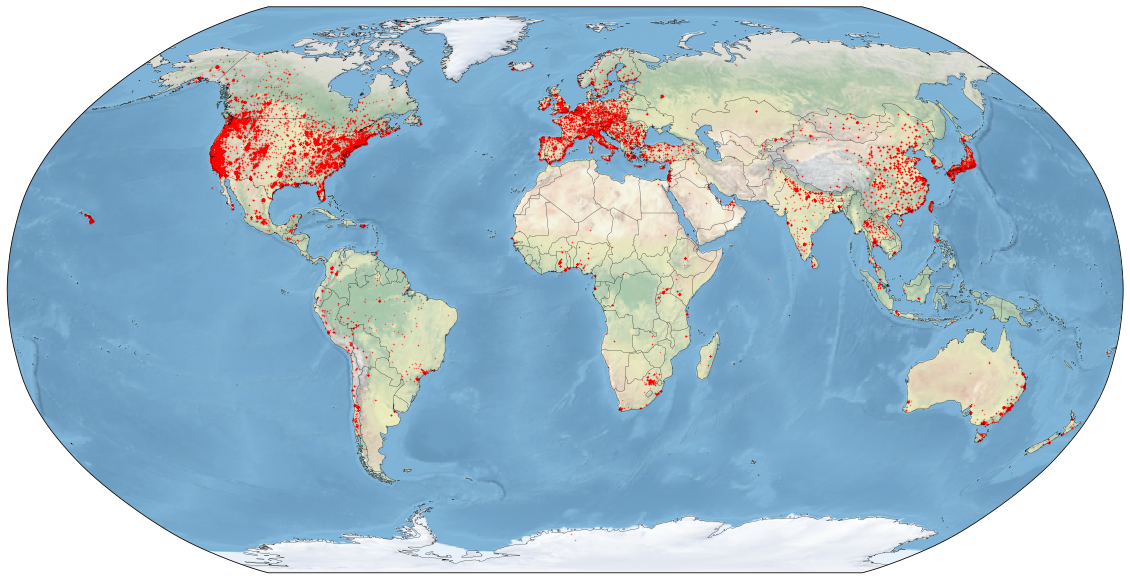

In [17]:
# import plotting packages used to make the map
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

# map the station locations as red dots
# setup the map projection and background
fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.coastlines(resolution='50m', lw=.25)
ax.add_feature(cf.BORDERS, lw=.25)
ax.stock_img()

# plot the locations
ax.scatter(x=locations_df['coordinates.longitude'], y=locations_df['coordinates.latitude'],
          transform=ccrs.PlateCarree(), # this argument ensures the coordinates are converted from lat/lon into map coords
          marker='.', color='red', s=1, alpha=.5)
ax.set_global()

fig.savefig('./figs/openaq_world_map.png', bbox_inches='tight', dpi=500)

But how many locations are still reporting? If we repeat the map but filtering by the `datetime_last.local` field, we can see how many locations have reported during 2024: 

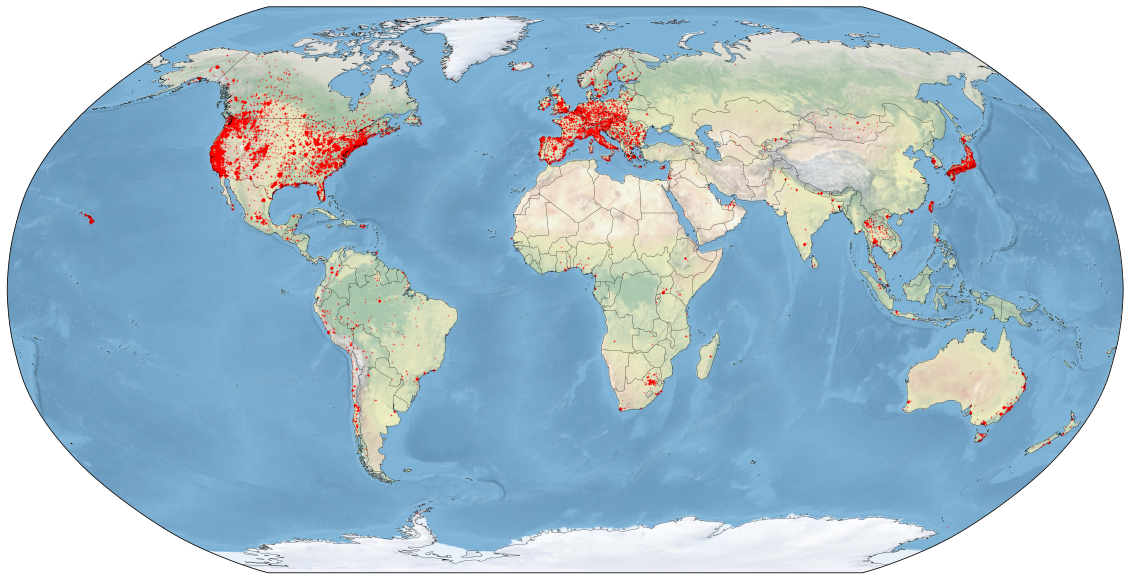

In [9]:
# which locations have reported during 2024?
recent_report = locations_df['datetime_last.local'] > '2024'

# map the station locations as red dots
# setup the map projection and background
fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.coastlines(resolution='50m', lw=.25)
ax.add_feature(cf.BORDERS, lw=.25)
ax.stock_img()

# plot the locations
ax.scatter(x=locations_df.loc[recent_report, 'coordinates.longitude'], 
           y=locations_df.loc[recent_report, 'coordinates.latitude'],
          transform=ccrs.PlateCarree(), # this argument ensures the coordinates are converted from lat/lon into map coords
          marker='.', color='red', s=1, alpha=.5)
ax.set_global()

fig.savefig('./figs/openaq_world_map_recent.png', bbox_inches='tight', dpi=500)

And recently OpenAQ has announced that they will no longer have access to data from the popular PurpleAir monitoring network. By filtering using the `provider.name` field we can plot a map without the pupleair stations (and only showing the stations that have reported during 2024)

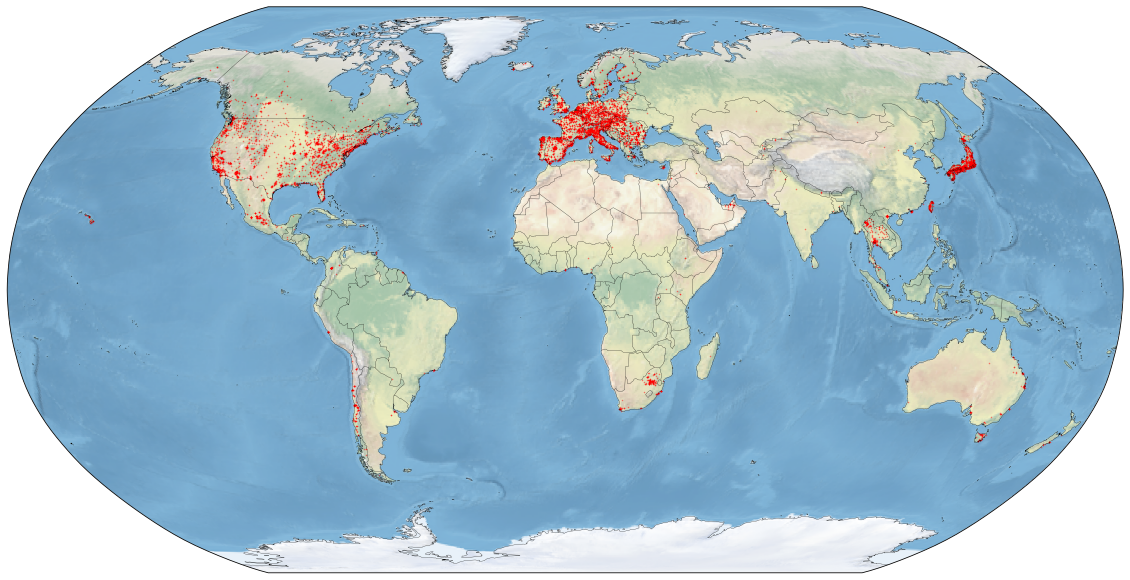

In [23]:
# filter based on PurpleAir
without_purpleair = locations_df['provider.name'] != 'PurpleAir'
recent_not_purpleair = without_purpleair & recent_report

# map the station locations as red dots
# setup the map projection and background
fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.coastlines(resolution='50m', lw=.25)
ax.add_feature(cf.BORDERS, lw=.25)
ax.stock_img()

# plot the locations

ax.scatter(x=locations_df.loc[recent_not_purpleair, 'coordinates.longitude'], 
           y=locations_df.loc[recent_not_purpleair, 'coordinates.latitude'],
          transform=ccrs.PlateCarree(), # this argument ensures the coordinates are converted from lat/lon into map coords
          marker='.', color='red', s=1, alpha=.5)
ax.set_global()

fig.savefig('./figs/openaq_world_map_without_purpleair.png', bbox_inches='tight', dpi=500)